In [7]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
factory_prod = pd.read_csv('data/production.csv')
# convert predictors into proper datatype
factory_prod['Confirmation'] = factory_prod['Confirmation'].astype(str)
factory_prod['Ordre'] = factory_prod['Ordre'].astype(str)
factory_prod['Poste de travail'] = factory_prod['Poste de travail'].astype(str)
factory_prod['Centre de coûts'] = factory_prod['Centre de coûts'].astype(str)
factory_prod['sku'] = factory_prod['sku'].astype(str)

factory_prod['at'] = pd.to_datetime(factory_prod['at'])
factory_prod = factory_prod.sort_values(by=['at'], ascending=True).reset_index(drop=True)

print( factory_prod.dtypes )

Confirmation                     object
Ordre                            object
Poste de travail                 object
Centre de coûts                  object
sku                              object
units                             int64
weight_kg                       float64
scrap                             int64
group                            object
at                  datetime64[ns, UTC]
dtype: object


In [6]:
factory_prod[['units', 'weight_kg', 'scrap']].corr()

,units,weight_kg,scrap
units,1.000000,0.067563,-0.007269
weight_kg,0.067563,1.000000,-0.031836
scrap,-0.007269,-0.031836,1.000000


# Units

In [8]:
var_to_predict = 'weight_kg'

data_unit = factory_prod.drop(['Confirmation', 'Ordre', 'at'], axis=1)
data_unit_num = data_unit.select_dtypes(include=['int64', 'float64']).drop([var_to_predict], axis=1)
data_unit_cat = data_unit.select_dtypes(exclude=['int64', 'float64'])
n_train = math.floor(0.9 * len(data_unit))

# split into train / test
trainX_num = data_unit_num[0:n_train]
trainY = data_unit[[var_to_predict]][0:n_train]

testX_num = data_unit_num[n_train:]
testY = data_unit[[var_to_predict]][n_train:]

# apply normalization and one-hot encoding
scaler = MinMaxScaler()
trainX_num = scaler.fit_transform(trainX_num)
testX_num = scaler.transform(testX_num)

data_unit_cat = pd.get_dummies(data_unit_cat)

# get final train and test set
data_scaled = pd.DataFrame(
    np.concatenate((np.concatenate((trainX_num, testX_num), axis=0), data_unit_cat), axis=1),
    columns=list(data_unit_num.columns) + list(data_unit_cat.columns)
)

trainX = data_scaled[0:n_train]
testX = data_scaled[n_train:]

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(8443, 534) (8443, 1)
(939, 534) (939, 1)


In [49]:
train_dataset = np.concatenate((trainX, trainY), axis=1)
test_dataset = np.concatenate((testX, testY), axis=1)

print(train_dataset.shape, test_dataset.shape)

(8443, 535) (939, 535)


In [50]:
# Function to process the data into # look_back days, # predict days slices
def convert_ts(data, look_back, look_forward):
    datX, datY = [], []
    for i in range(len(data)-look_back-look_forward+1):
        a = data[i:(i+look_back), :]
        datX.append(a)
        datY.append(data[i+look_back+look_forward-1, -1])
    return np.array(datX), np.array(datY).reshape(-1, 1)

In [51]:
# convert data into lagged data
look_back = 60
look_forward = 10
trainX_ts, trainY_ts = convert_ts(train_dataset, look_back, look_forward)
testX_ts, testY_ts = convert_ts(test_dataset, look_back, look_forward)

print( trainX_ts.shape, trainY_ts.shape )
print( testX_ts.shape, testY_ts.shape )

(8374, 60, 535) (8374, 1)
(870, 60, 535) (870, 1)


In [52]:
from keras.api.models import Sequential
from keras.api.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from keras.api.callbacks import EarlyStopping

from sklearn.metrics import root_mean_squared_error

In [53]:
# define model
def create_lstm():
    model = Sequential()
    model.add(LSTM(50))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    return model

In [54]:
# define model, criterion, and optimizer
model = create_lstm()
model.compile(optimizer='adam', loss='mean_squared_error')

# train model
model_hist = model.fit(
    trainX_ts, trainY_ts,
    epochs=50, batch_size=60*24
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 141322.2969
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 130186.6406
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 121966.5234
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 132986.4688
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 135697.5781
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 133442.1562
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 121403.5938
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 129372.4688
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 126879.6641
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 125155.7266
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 122833.6953
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 117164.8984
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 122946.2812
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 111505.5312
Epoch 15/50
6/6

In [55]:
# prediction
train_preds = model.predict(trainX_ts)
test_preds = model.predict(testX_ts)

print('RMSE train: ', root_mean_squared_error(trainY_ts, train_preds))
print('RMSE test: ', root_mean_squared_error(testY_ts, test_preds))

262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE train:  304.9930949101344
RMSE test:  354.06974379386793


Text(0.5, 1.0, 'weight_kg over time')

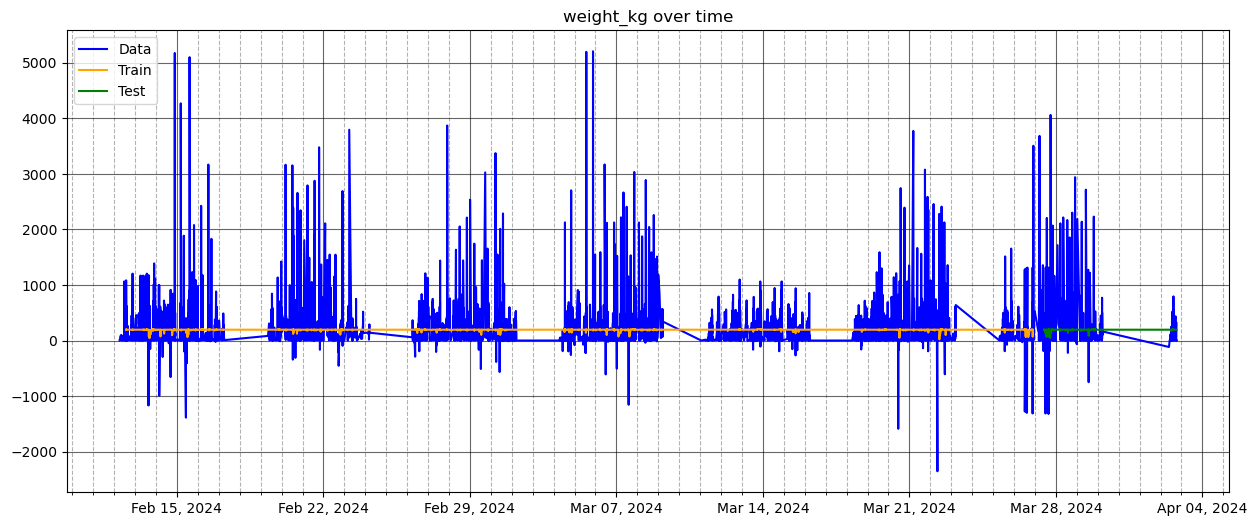

In [56]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.full(factory_prod[[var_to_predict]].shape, np.nan)
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds), :] = train_preds.reshape(-1,1)

test_predict_plot = np.full(factory_prod[[var_to_predict]].shape, np.nan)
test_predict_plot[(2*(look_back+look_forward-1)+len(train_preds)):(2*(look_back+look_forward-1)+len(train_preds)+len(test_preds)), :] = test_preds.reshape(-1,1)

plt.plot(factory_prod['at'], factory_prod[var_to_predict], color='blue', label='Data')
plt.plot(factory_prod['at'], train_predict_plot, color='orange', label='Train')
plt.plot(factory_prod['at'], test_predict_plot, color='green', label='Test')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
# plt.yscale("log") 
plt.legend(loc='upper left')
plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)  
plt.title(var_to_predict + ' over time')

Text(0.5, 1.0, 'weight_kg over time')

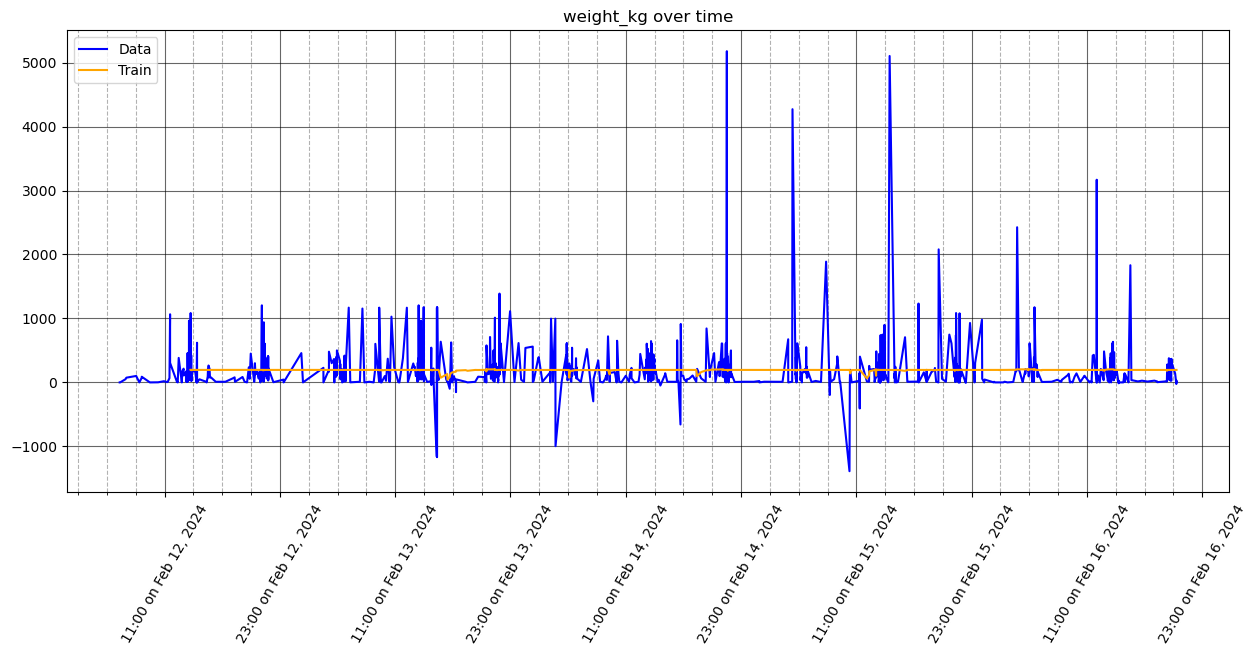

In [75]:
fig, ax = plt.subplots(figsize=(15,6))

num_obs = 1200
train_predict_plot = np.full(factory_prod[[var_to_predict]][:num_obs].shape, np.nan)
train_predict_plot[look_back+look_forward-1:, :] = train_preds.reshape(-1,1)[:(num_obs-(look_back+look_forward-1))]

plt.plot(factory_prod['at'][:num_obs], factory_prod[var_to_predict][:num_obs], color='blue', label='Data')
plt.plot(factory_prod['at'][:num_obs], train_predict_plot, color='orange', label='Train')

ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M on %b %d, %Y'))

plt.xticks(rotation=60)
# plt.yscale("log") 

plt.legend(loc='upper left')
plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)  
plt.title(var_to_predict + ' over time')